In [1]:
import numpy as np
import tqdm 
import matplotlib.pyplot as plt
from astropy.constants import G
import matplotlib as mpl
import sys
from scipy import interpolate
from scipy.integrate import simps
from matplotlib import colors 
import warnings

sys.path.append('../my_funcs/')
from pipeline_main import pipeline

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)


In [2]:
data = pipeline(snap = 357, run = 'my_core_13lacc', sink_id=13)
data.recalc_L(verbose = 1); 
data.calc_disksize(plot = False); data.calc_trans_xyz()

Initialising patch data


100%|██████████| 4165/4165 [00:03<00:00, 1257.09it/s]


Converged mean angular momentum vector after 0 iteration(s)
Looping through patches, assigning azimuthal velocities to all cells and extracing them within given cylindrical coordiantes


100%|██████████| 4165/4165 [00:00<00:00, 8964.33it/s] 


Disk size: 17.9 au
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5084.68it/s]


In [3]:
def _fill_2Dhist(self, hist, orig_coor, new_coor, method = 'linear', periodic_x = True):
    x, y = orig_coor; x_new, y_new = new_coor
    if periodic_x:
        hist = np.vstack((hist[-10:], hist, hist[:10]))
        x = np.concatenate((x[0] - x[:10][::-1], x, x[-1] + x[:10]))

    xx, yy = np.meshgrid(x, y, indexing = 'ij')
    xx_new, yy_new = np.meshgrid(x_new, y_new, indexing='ij')
    ma = np.ma.masked_array(hist.flatten(), mask = np.isnan(hist.flatten()))
    interpolation = interpolate.griddata(np.hstack((xx.flatten()[:,None][~ma.mask], yy.flatten()[:,None][~ma.mask])), ma[~ma.mask], xi = (xx_new, yy_new), method = method, fill_value=np.nanmin(hist))
    return interpolation
pipeline._fill_2Dhist = _fill_2Dhist

In [17]:
def L_transport(self, radius = 90, Nh = 100, N_phi = 200, refine_grid = 2, shell_Δ = 1, plot = True):
    Nr = int(2 * Nh); N_phi_v = N_phi // 2; height = radius
    G_cgs = G.to('cm**3 / (g * s**2)').value
    radius /= self.au_length; height /= self.au_length; shell_Δ /= self.au_length
    selection_radius = np.sqrt(radius**2 + height**2) * 2

    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    print(f'Using {len(sorted_patches)} patches to retrive angular momentum change')


    #__________________________________________________EXTRACTING KNOWLEDGE OF THE RADIAL PART OF THE STRESS___________________________________________________


    extracted_values =  {key: [] for key in range(7)}
    print('Calculating radial part')
    for p in sorted_patches:
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
        if len(leafs) == 8: continue

        to_extract = (p.cyl_R > radius - shell_Δ) & (p.cyl_R <  radius + shell_Δ)
        p.B = np.concatenate([p.var(f'b'+axis)[None,...] for axis in ['x','y','z']], axis = 0)
        p.gradφ = np.array(np.gradient(p.var('phi'), p.ds[0], edge_order = 2))
        p.Bφ = np.sum(p.B * p.e_φ, axis = 0)
        p.Br = np.sum(p.B * p.e_r, axis = 0)
        p.vφ = np.sum(p.vrel * p.e_φ, axis = 0)
        p.vr = np.sum(p.vrel * p.e_r, axis = 0)
        p.gradφ_φ = np.sum(p.gradφ * p.e_φ, axis = 0)
        p.gradφ_r = np.sum(p.gradφ * p.e_r, axis = 0)
        
        
        for lp in leafs: 
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool 
        
        z_coor = p.cyl_z[to_extract].T 
        φ_coor = p.φ[to_extract].T
        vel_φr = p.vr[to_extract].T * p.vφ[to_extract].T
        B_φr =  p.Br[to_extract].T * p.Bφ[to_extract].T
        mass_val = p.m[to_extract].T 
        gradφ_φr = p.gradφ_r[to_extract].T * p.gradφ_φ[to_extract].T
        
        extracted_values[0].extend(z_coor.tolist())
        extracted_values[1].extend(φ_coor.tolist())
        extracted_values[2].extend(vel_φr.tolist())
        extracted_values[3].extend(mass_val.tolist())
        extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
        extracted_values[5].extend(B_φr.tolist())
        extracted_values[6].extend(gradφ_φr.tolist())

    for key in extracted_values:
        extracted_values[key] = np.array(extracted_values[key])

    #Making grid in height and phi direction:
    z_grid = np.linspace(-height, height, Nh); phi_grid = np.linspace(0, 2 * np.pi, N_phi)

    #Binning values
    hist_mass, binedges_phi, binedges_z = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[3])
    hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, z_grid), weights = extracted_values[4])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        hist_vφvr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
        hist_BφBr = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
        hist_gradφ_φr =np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, z_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

        hist_ρ = hist_mass/hist_vol

    if (hist_mass == 0).any: print('Radial 2D histogram not completely covered')
    reynolds_radial = - hist_vφvr * hist_ρ * self.cms_velocity**2 * self.cgs_density
    maxwell_radial = hist_BφBr / (4 * np.pi) * self.sn.scaling.b**2
    grav_radial = hist_gradφ_φr / (4 * np.pi * G_cgs) * (self.cms_velocity / self.sn.scaling.t)**2

    z_bins = z_grid[:-1] + 0.5 * np.diff(binedges_z)
    phi_bins = phi_grid[:-1] + 0.5 * np.diff(binedges_phi)

    znew_grid = np.linspace(-height, height, Nh * refine_grid); phinew_grid = np.linspace(0, 2 * np.pi, N_phi * refine_grid)

    reynolds_Ir = self._fill_2Dhist(reynolds_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)
    maxwell_Ir = self._fill_2Dhist(maxwell_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)
    grav_Ir = self._fill_2Dhist(grav_radial, orig_coor=[phi_bins, z_bins], new_coor=[phinew_grid, znew_grid], periodic_x=True)


    #__________________________________________________PLOTTING THE RADIAL PART OF THE STRESS_______________________________________________________

    tick_labels = ['$\pi$/3','2$\pi$/3','$\pi$', '4$\pi$/3', '5$\pi$/3', '2$\pi$']
    tick_values = [np.pi/3, 2*np.pi/3, np.pi, np.pi/3 + np.pi, 2*np.pi/3 + np.pi, 2*np.pi]
    stress_names = ['Reynolds', 'Maxwells', 'Grav. instability', 'Total']

    if plot:
        fig, axs = plt.subplots(4,1, figsize = (20,16))
        for ax in axs.flatten():
            ax.set(ylabel = '[AU]', xlim = (0, 2*np.pi))

        ytick = radius * self.au_length // 2

        ax = axs[0]
        ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels); ax.xaxis.tick_top()

        for ax in axs.flatten()[1:3]:
            ax.set_xticklabels([])
            
        total_stress_R = reynolds_Ir + maxwell_Ir + grav_Ir
        ax = axs[-1]
        ax.set_xticks(tick_values); ax.set_xticklabels(tick_labels);
        ax.pcolormesh(phinew_grid, znew_grid * self.au_length, total_stress_R.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
        ax.set_yticks([-ytick,0, ytick])
        ax.text(0.99, 0.95, 'Total', transform=ax.transAxes, ha='right', va='top', fontsize = 24)


        for ax, stress, name in zip(axs.flatten(), [reynolds_Ir, maxwell_Ir, grav_Ir], stress_names):
            cs = ax.pcolormesh(phinew_grid, znew_grid * self.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
            ax.set_yticks([-ytick,0, ytick])
            ax.text(0.99, 0.95, name, transform=ax.transAxes, ha='right', va='top', fontsize = 24)


        fig.subplots_adjust(wspace=0, hspace=0)
        cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.01)
        cbar.set_label('Energy density [Ba]',fontsize = 18)
    
    
    #___________________________________CALCULATING THE INTEGRAL (RADIAL) TO GET TOTAL CHANGE I ANGULAR MOMENTUM__________________________________________
    R = radius * self.sn.scaling.l
    ΔL_Rr = simps(simps(reynolds_Ir * R**2, phinew_grid, axis = 0), znew_grid * self.sn.scaling.l)
    ΔL_Mr = simps(simps(maxwell_Ir * R**2, phinew_grid, axis = 0), znew_grid * self.sn.scaling.l)
    ΔL_Gr = simps(simps(grav_Ir * R**2, phinew_grid, axis = 0), znew_grid * self.sn.scaling.l)


    #__________________________________________EXTRACTING KNOWLEDGE OF THE VERTICAL PART OF THE STRESS___________________________________________________

    #Looping over top and then bottom of the cylinder:
    for top in [1, 0]:

        extracted_values =  {key: [] for key in range(7)} # So far this is only for densities and velocities
        print('Calculating vertical part')
        for p in sorted_patches:
            nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
            children = [ n for n in nbors if n.level == p.level + 1]
            leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
            if len(leafs) == 8: continue

            if top == True:
                to_extract = (p.cyl_z > height - shell_Δ) & (p.cyl_z <  height + shell_Δ)
            elif top == False:
                to_extract = (p.cyl_z > - height - shell_Δ) & (p.cyl_z < - height + shell_Δ)

            p.Bz = np.sum(p.B * self.L[:,None, None, None], axis = 0)
            p.vz = np.sum(p.vrel * self.L[:,None, None, None], axis = 0)
            p.gradφ_z = np.sum(p.gradφ * self.L[:,None, None, None], axis = 0)
            
            for lp in leafs: 
                leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
                covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
                to_extract *= covered_bool 
            
            r_coor = p.cyl_R[to_extract].T 
            φ_coor = p.φ[to_extract].T
            vel_φz = p.vz[to_extract].T * p.vφ[to_extract].T
            B_φz =  p.Bz[to_extract].T * p.Bφ[to_extract].T
            mass_val = p.m[to_extract].T 
            gradφ_φz = p.gradφ_r[to_extract].T * p.gradφ_z[to_extract].T
            
            extracted_values[0].extend(r_coor.tolist())
            extracted_values[1].extend(φ_coor.tolist())
            extracted_values[2].extend(vel_φz.tolist())
            extracted_values[3].extend(mass_val.tolist())
            extracted_values[4].extend(p.ds[0]**3 * np.ones(len(mass_val)))
            extracted_values[5].extend(B_φz.tolist())
            extracted_values[6].extend(gradφ_φz.tolist())

        for key in extracted_values:
            extracted_values[key] = np.array(extracted_values[key])

        #Making grid in height and phi direction:
        r_grid = np.logspace(np.log10(1e-3 / self.au_length), np.log10(radius), Nr); phi_grid = np.linspace(0, 2 * np.pi, N_phi_v)

        #Binning values
        hist_mass, binedges_phiv, binedges_r = np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[3])
        hist_vol, _, _ =  np.histogram2d(extracted_values[1], extracted_values[0], bins = (phi_grid, r_grid), weights = extracted_values[4])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            hist_vφvz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[2] * extracted_values[3])[0] / hist_mass 
            hist_BφBz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[5] * extracted_values[3])[0] / hist_mass 
            hist_gradφ_φz = np.histogram2d(extracted_values[1], extracted_values[0],  bins = (phi_grid, r_grid), weights = extracted_values[6] * extracted_values[3])[0] / hist_mass 

            hist_ρ = hist_mass/hist_vol
        if (hist_mass == 0).any and top == True: print('Vertical (top) 2D histogram not completely covered')
        if (hist_mass == 0).any and top == False: print('Vertical (bottom) 2D histogram not completely covered')
        if top == True:
            reynolds_vertical = - hist_vφvz * hist_ρ * self.cms_velocity**2 * self.cgs_density
            maxwell_vertical = hist_BφBz / (4 * np.pi) * self.sn.scaling.b**2
            grav_vertical = - hist_gradφ_φz / (4 * np.pi * G_cgs) * (self.cms_velocity / self.sn.scaling.t)**2
            
        elif top == False:
            reynolds_vertical = hist_vφvz * hist_ρ * self.cms_velocity**2 * self.cgs_density
            maxwell_vertical = - hist_BφBz / (4 * np.pi) * self.sn.scaling.b**2
            grav_vertical = hist_gradφ_φz / (4 * np.pi * G_cgs) * (self.cms_velocity / self.sn.scaling.t)**2

        r_bins = r_grid[:-1] + 0.5 * np.diff(binedges_r)
        phi_binsv = phi_grid[:-1] + 0.5 * np.diff(binedges_phiv)

        rnew_grid =np.logspace(np.log10(1e-3 / self.au_length), np.log10(radius), Nr * refine_grid); 
        phinew_gridv = np.linspace(0, 2 * np.pi, N_phi_v * refine_grid)

        if top == True:
            reynolds_Iv = self._fill_2Dhist(reynolds_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)
            maxwell_Iv = self._fill_2Dhist(maxwell_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)
            grav_Iv = self._fill_2Dhist(grav_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)

        elif top == False:
            reynolds_Iv += self._fill_2Dhist(reynolds_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)
            maxwell_Iv += self._fill_2Dhist(maxwell_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)
            grav_Iv += self._fill_2Dhist(grav_vertical, orig_coor=[phi_binsv, r_bins], new_coor=[phinew_gridv, rnew_grid], periodic_x=True)



    #__________________________________________________PLOTTING THE RADIAL PART OF THE STRESS_______________________________________________________


    if plot:
        fig, axs = plt.subplots(2,2, figsize = (20,20), subplot_kw={'projection' :'polar'})

        for ax in axs.flatten():
            ax.set_xticks([]); ax.set_xticklabels([])
            ax.set_yticks([])
            
        total_stress_V = reynolds_Iv + maxwell_Iv + grav_Iv
        ax = axs.flatten()[-1]
        ax.set_xticks([]); ax.set_xticklabels([]);
        ax.pcolormesh(phinew_gridv, rnew_grid * self.au_length, total_stress_V.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
        ax.set(title = 'Total')

        for ax, stress, name in zip(axs.flatten(), [reynolds_Iv, maxwell_Iv, grav_Iv], stress_names):
            cs = ax.pcolormesh(phinew_gridv, rnew_grid * self.au_length, stress.T, norm = colors.SymLogNorm(linthresh=1e-10, linscale=0.5, vmin = -1e-5, vmax = 1e-5), snap = True, shading = 'gouraud', cmap = 'coolwarm')
            ax.set(title = name)

        fig.subplots_adjust(wspace=0, hspace=0.01)
        cbar = fig.colorbar(cs, ax=axs.ravel().tolist(), fraction = 0.04, pad = 0.02)
        cbar.set_label('Energy density [Ba]',fontsize = 18)


    #___________________________________CALCULATING THE INTEGRAL (RADIAL) TO GET TOTAL CHANGE I ANGULAR MOMENTUM__________________________________________


    r = rnew_grid * self.sn.scaling.l
    ΔL_Rv = simps(simps(reynolds_Iv * r**2, phinew_gridv, axis = 0), r)
    ΔL_Mv = simps(simps(maxwell_Iv * r**2, phinew_gridv, axis = 0), r)
    ΔL_Gv = simps(simps(grav_Iv * r**2, phinew_gridv, axis = 0), r)



    #________________________________________________CALCULATING TOTAL ANGULAR MOMENTUM WITHIN CYLINDER_______________________________________________


    def calc_L(height = height, radius = radius):
        print('Calculating total angular momentum within the cylinder')
        if not self.cyl_calculated: self.calc_cyl()

        pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
        w= np.array([p.level for p in pp]).argsort()[::-1]
        sorted_patches = [pp[w[i]] for i in range(len(pp))]

        L_new = np.zeros(3)
        for p in sorted_patches:
            nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
            children = [ n for n in nbors if n.level == p.level + 1]
            leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]   
            if len(leafs) == 8: continue

            to_extract = (p.cyl_R < radius) & ((abs(p.cyl_z) < height))
            for lp in leafs: 
                leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
                covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
                to_extract *= covered_bool 

            L_patch = np.cross(p.rel_xyz, p.vel_xyz * p.m , axisa=0, axisb=0, axisc=0)
            L_new += np.array([np.sum(L_patch[axis][to_extract]) for axis in range(3)])
        return L_new * self.sn.scaling.m * self.cms_velocity * self.sn.scaling.l
    
    L_total = np.linalg.norm(calc_L())

    # The order of the computed loss of angular momentum is:
    # 'Reynolds', 'Maxwells', 'Grav. instability', 'Total'
    # 1. The cylinder walls, 2. The cylinder top and bottom compined
    # Everything is in cgs units so g*cm^22 / s^2 for the integral parts

    def stresses(self):
        print(f'Stresses for radius = {radius * self.au_length:2.0f} au, height = {2 * radius * self.au_length:2.0f} au')
        print('Order of stresses:',stress_names,'\n0: Radial\n1: Vertical\n2: Total angular momentum')
        print('All values are givin in cgs-units')
        radial = np.array([ΔL_Rr, ΔL_Mr, ΔL_Gr, ΔL_Rr + ΔL_Mr + ΔL_Gr])
        vertical = np.array([ΔL_Rv, ΔL_Mv, ΔL_Gv, ΔL_Rv + ΔL_Mv + ΔL_Gv])
        return radial, vertical, L_total
    
    pipeline.stresses = stresses
    
pipeline.L_transport = L_transport

Using 1376 patches to retrive angular momentum change
Calculating radial part
Radial 2D histogram not completely covered
Calculating vertical part
Vertical (top) 2D histogram not completely covered
Calculating vertical part
Vertical (bottom) 2D histogram not completely covered
Calculating total angular momentum within the cylinder


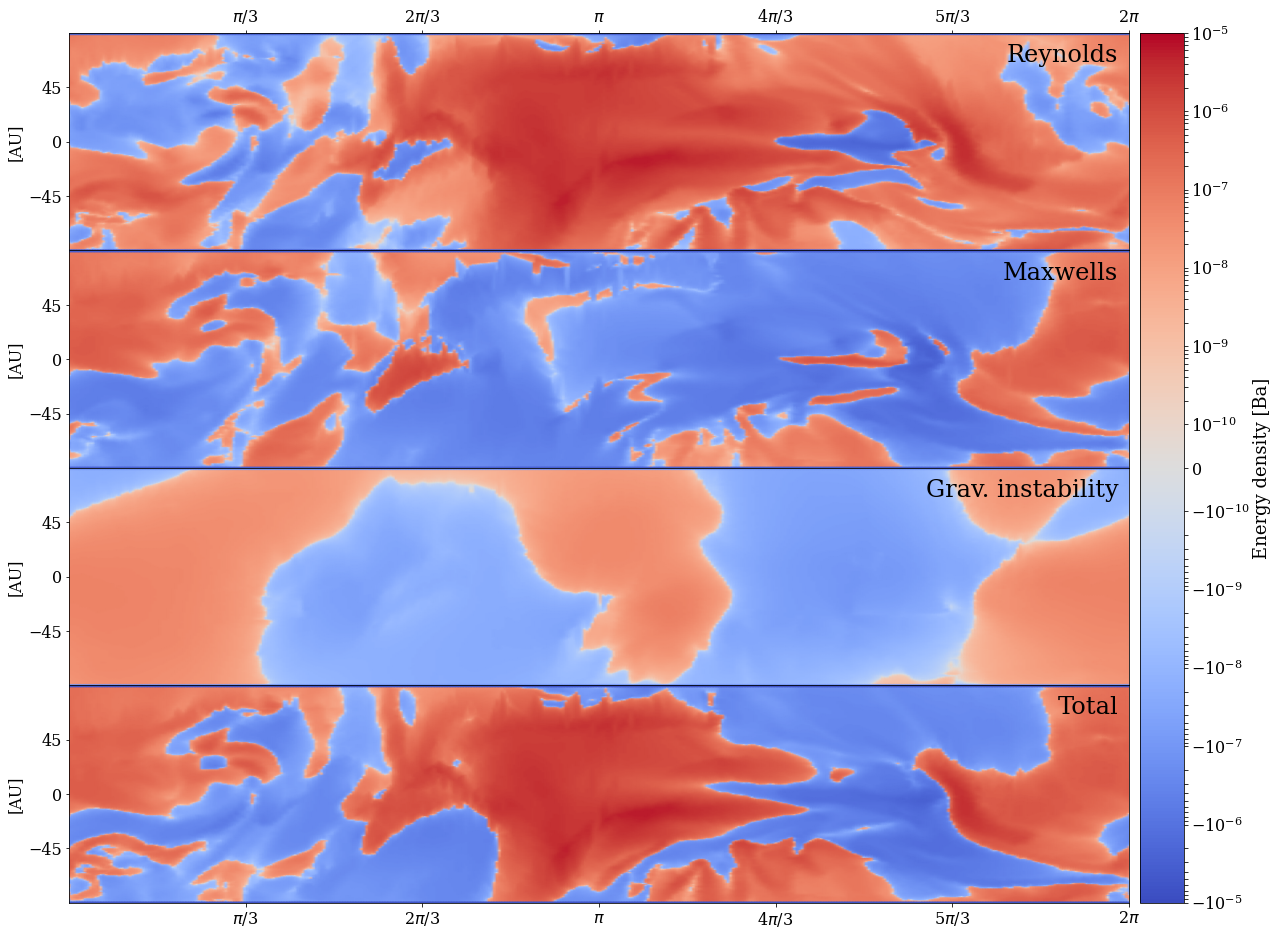

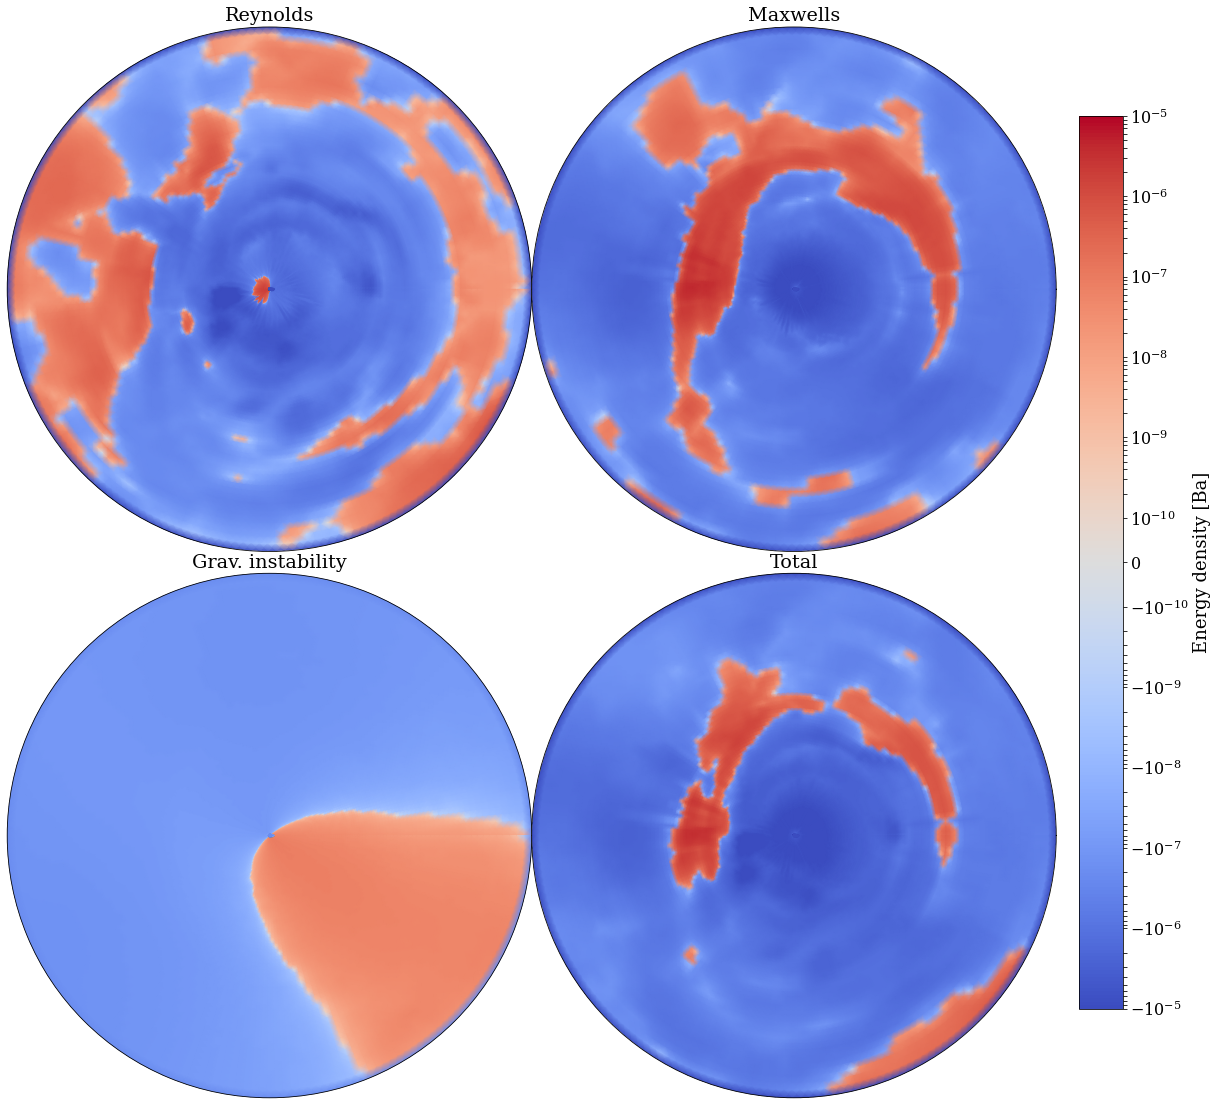

In [18]:
data.L_transport()

In [19]:
data.stresses()

Stresses for radius = 90 au, height = 180 au
Order of stresses: ['Reynolds', 'Maxwells', 'Grav. instability', 'Total'] 
0: Radial
1: Vertical
2: Total angular momentum
All values are givin in cgs-units


(array([ 1.12142049e+40, -5.47132385e+39, -3.43832153e+37,  5.70849786e+39]),
 array([-6.18639944e+39, -4.66101751e+39, -3.45250380e+38, -1.11926673e+40]),
 3.496915237514938e+50)